In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt



def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

# Analisis de hiperparametros

Para analizar los hiperparametros, consideraremos diferentes estructuras ya que manejamos diferentes tipos de hamiltonianos

Para el molecular, consideramos (consideramos la base "sto-3g"):
1. Dimero de hidrogeno
2. Helium hydride ion

Lo siguiente es ver que hiperparemetros vamos a estudiar:
1. Optimizador:
    1. Tipo de optimizador
    2. Learning rate (si corresponde)
2. Ansatz:
    1. Tipo de ansatz
    2. Repeticiones del ansatz

Considerando la conversion $1$ ev es $0.036749$ Hartree, se seteara como valor fijo una tolerancia de $1e-6$, la cantidad de iteraciones sera una variable y no un valor fijo.

## Moleculas

In [2]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule1 = vqe_molecular(symbols, coordinates, params)
molecule1.set_group_characteristics()

symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
params = {
    'mapping': "jordan_wigner",
    'charge': 1, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

#Construccion de la clase
molecule2 = vqe_molecular(symbols, coordinates, params)
molecule2.set_group_characteristics()
print(molecule1.qubits, molecule2.qubits)

4 4


## Dimero de hidrogeno

#### KUPCCGSD Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [3]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule1.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


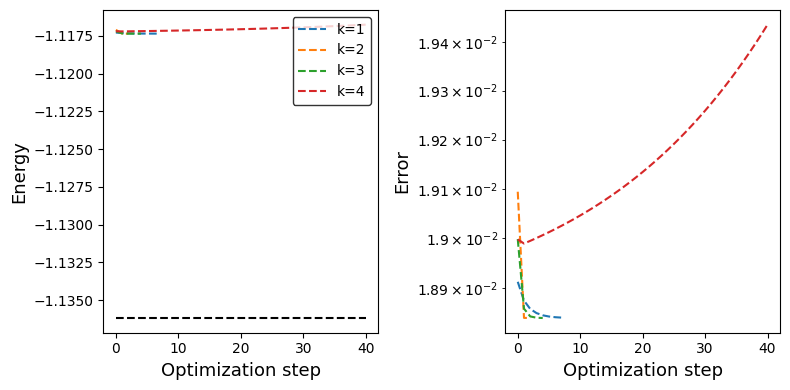

In [4]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### UCCDS Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [6]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


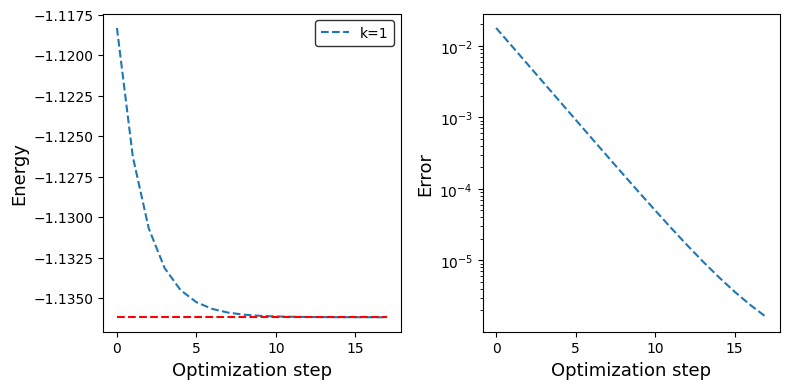

In [7]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### HE Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [12]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": molecule1.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function_parallel)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


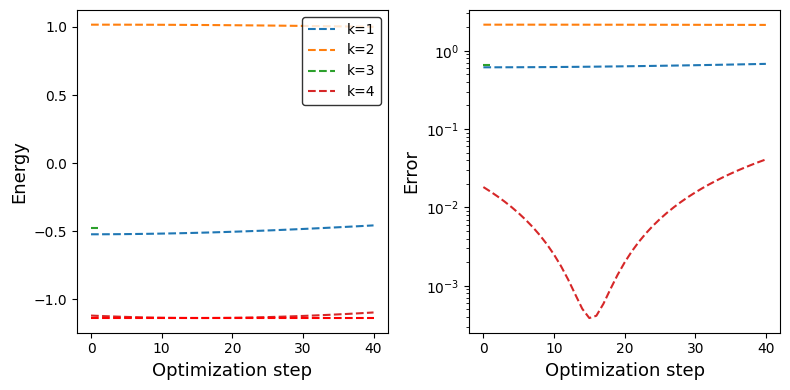

In [13]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

Resumen:
1. el KUPCCGSD Ansatz da malos resultados independiente de las repeticiones.
2. el UCCDS Ansatz da buenos resultados desde $k=1$
3. el HE Ansatz da buenos resultados desde $k=2$

Conclusion, quedarnos con UCCDS para el dimero de hidrogeno (menor numero de repeticiones)

### Optimizadores
Ahora que filtramos los ansatz, lo siguiente es estudiar los tipos de optimizadores

Para los ansatz, usaremos los $k$ indicados en el punto anterior

#### Gradiente generico - UCCDS Ansatz

In [9]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }
ansazt = uccds_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )

learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", k]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

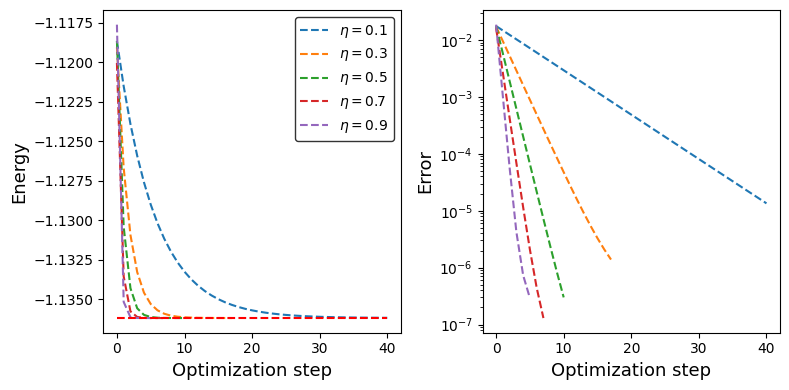

In [10]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### Adam - UCCDS Ansatz

In [11]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }
ansazt = uccds_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )

learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["adam", k]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

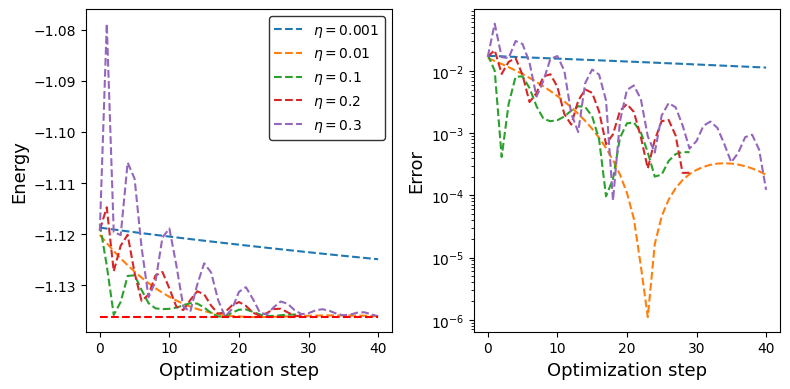

In [12]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### AdaGrad - UCCDS Ansatz

In [13]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": molecule1.qubits,
        "pattern": "chain"
    }
ansazt = uccds_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )

learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["adagrad", k]}

    molecule1.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule1.cost_function)
    valores.append(energy1)

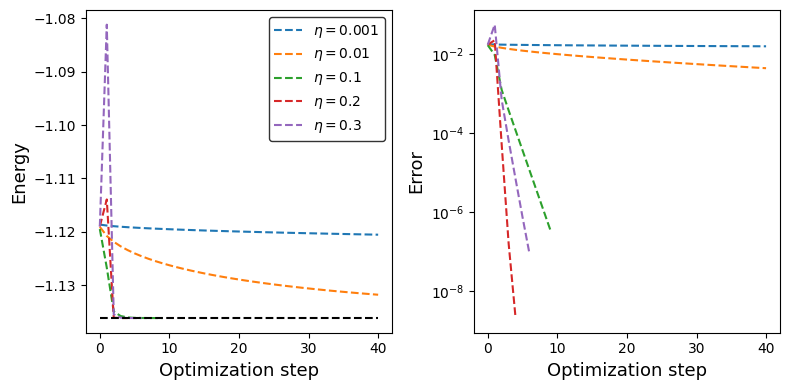

In [14]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

Todos los optimizadores dan buenos resultados, pero con learning rate $0.1<=$

## Helium hydride ion

#### KUPCCGSD Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [3]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule2.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 1e-6,
            "number": a*b,
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


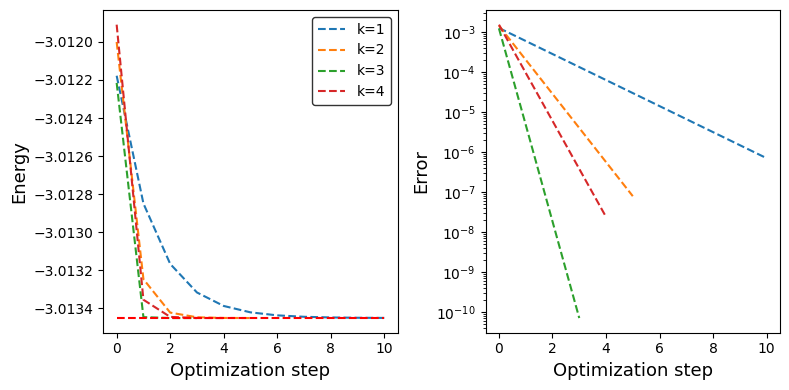

In [4]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### UCCDS Ansatz

Numero de electrones igual a la cantidad de electrones de valencia

In [5]:
valores = []
for k in range(1):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

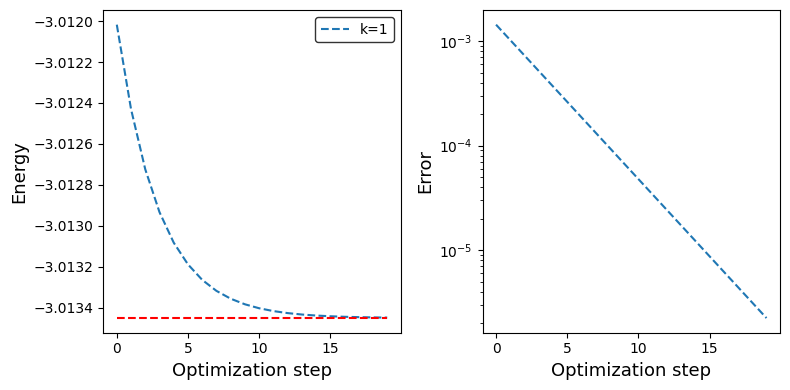

In [6]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [7]:
valores = []
for k in range(4):
    ansatz_params = {
        "repetitions": k+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number": molecule2.qubits*ansatz_params["repetitions"],
            "theta":["generic", 0.3]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

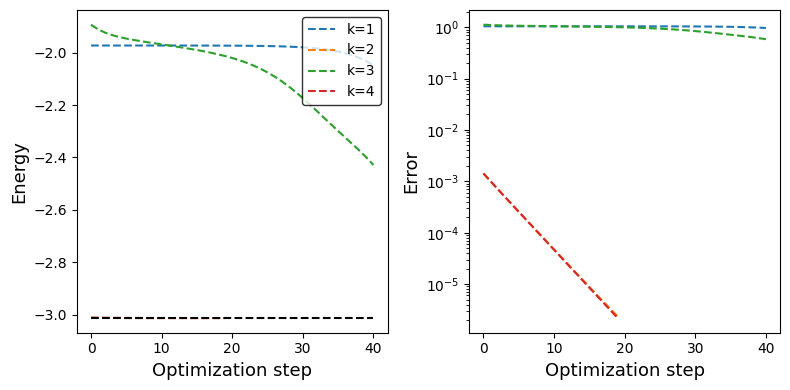

In [8]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="k="+str(i+1))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], color="black", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

Los mejores resultados lo entrega el KUPCCGSD Ansatz

### Optimizadores
Ahora que filtramos los ansatz, lo siguiente es estudiar los tipos de optimizadores

Para los ansatz, usaremos los $k$ indicados en el punto anterior

#### Gradiente generico - KUPCCGSD Ansatz

In [9]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }
ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule2.qubits, delta_sz=0)

learning_rate = [0.1, 0.3, 0.5, 0.7, 0.9]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  a*b,
            "theta":["generic", k]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

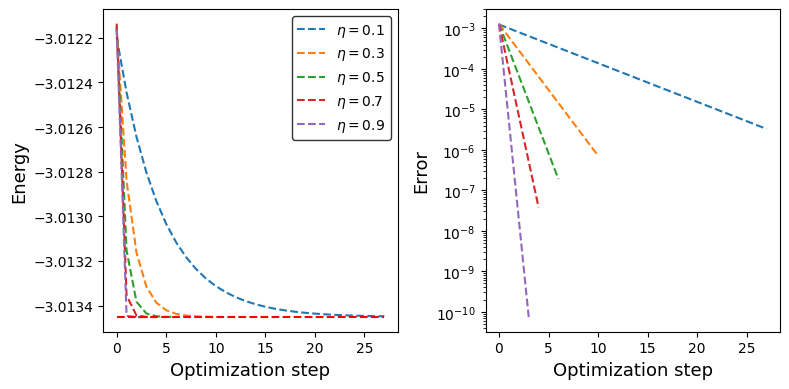

In [10]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### Adam - KUPCCGSD Ansatz

In [11]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }
ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule2.qubits, delta_sz=0)

learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  a*b,
            "theta":["adam", k]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

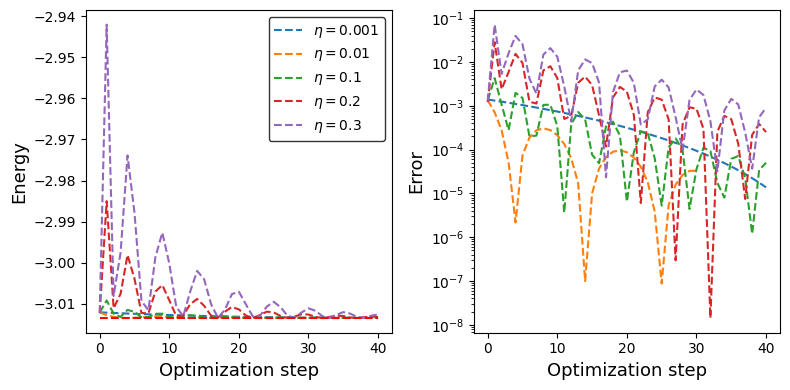

In [12]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

#### Adagrad - KUPCCGSD Ansatz

In [13]:
valores = []
ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": molecule2.qubits,
        "pattern": "chain"
    }
ansazt = upccgsd_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=molecule2.qubits, delta_sz=0)

learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

for k in learning_rate:
    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 40,
            "tol": 0.000001,
            "number":  a*b,
            "theta":["adagrad", k]}

    molecule2.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(molecule2.cost_function)
    valores.append(energy1)

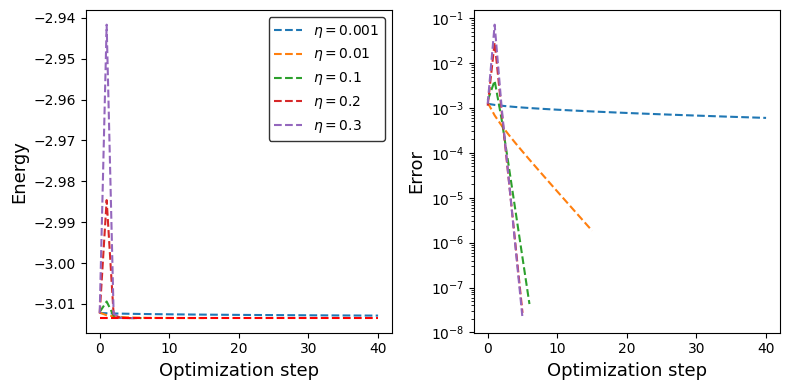

In [14]:
symbols = ["He", "H"]
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.4588], requires_grad=True)
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"], charge=1)

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)
aux = max( [len(i) for i in valores] )

for i, val in enumerate(valores):
    ax[0].plot([j for j in range(len(val))], val, ls="dashed", label="$\\eta=$"+str(learning_rate[i]))
    ax[1].plot([i for i in range(len(val))], [np.abs(val[j] -ee[0]) for j in range(len(val))], ls="dashed")
ax[0].plot([j for j in range( aux ) ], [ee[0] for j in range(aux)], "r", ls="dashed")
ax[1].set_yscale("log")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()